## **Introduction to Artificial Intelligence - Computer Assignment 2-HMM**

## *Amin Aghakasiri*
## *Student ID : 810101381*

### *Summary and Purpose of the project*
In this project, we are supposed to build an HMM model for audio recognition. What we should do in this project is the recognition of numbers from 0 to 9 using the HMM model that we train it using some voices from 6 different speakers that each one repeats each number a number of times. Also, our model should be able to predict the speaker based on the test voices too. So after training our model with 2 different approach (one the target variables are numbers and the other the target variables are speakers), we should test our model with some test data that we prepared. After that, we use some measurements in order to evaluate the quality of our model. These measurements are accuracy, precision, recall and F1 score that will be examined exactly in next parts.

In [41]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
from hmmlearn import hmm
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import scipy

### *Hyper-parameters*
Hyper-parameters are very important in machine learning algorithms becuase mostly we don't know the optimal solution in these problems (because of the various data that we have in these problems). So it is very important to change these parameters in order to find the better solution. Here are my hyper-parameters for this problem:
* `NUM_OF_ITERATIONS` : Number of iterations for making our models.
* `NUM_OF_HIDDEN_STATES_NUMBERS` : Number of states that we use in order to train the models for numbers.
* `NUM_OF_HIDDEN_STATES_SPEAKERS` : Number of states that we use in order to train the models for speakers.

In [42]:
NUM_OF_ITERATIONS = 10
NUM_OF_HIDDEN_STATES_NUMBERS = 6
NUM_OF_HIDDEN_STATES_SPEAKERS = 10

## *Part1 : Preprocess and Feature Extraction*
In this part, we should properly do the preprocessing step based on our needs and also extract the proper features for developing our model. I will shortly explain the functions and classes for this part:

#### 1. Class
* `Audio` : This class maintains the properties of each voice that I will use them in explaining different features that we can extract from audios.

#### 2. Functions

* `preprocess()` : This functions is used for preprocessing the data using librosa library in order to extract mfccs (that I will explain about in questions' part) and prepare the classes. The important thing that I've done is that I removed the silenced parts of voices in order to make my model more accurate. Also, I have make the shapes of arrays the same in `pad_to_desired_shape()` function to make my model.

* `seperate_test_train()` : This funtion seperates test and train data properly with a desired propotion (I used 80% of data for train and 20% for test).

* `show_mfccs_heat_map()` : This function show the heatmap for an input mfcc.

In [43]:
class Audio:
    def __init__(self, name, number, time, mfcc, signal,trimmed_signal) -> None:
        self.name = name
        self.number = number
        self.time = time
        self.mfcc = mfcc
        self.signal = signal
        self.trimmed_signal = trimmed_signal
    def get_name(self):
        return self.name
    def get_number(self):
        return self.number
    def get_time(self):
        return self.time
    def get_mfcc(self):
        return self.mfcc
    def get_signal(self):
        return self.signal
    def get_trimmed_signal(self):
        return self.trimmed_signal

In [44]:
def pad_to_desired_shape(array, desired_shape):
    n_repeats = int(np.ceil(desired_shape / array.shape[1]))  
    repeated_array = np.tile(array, (1 ,n_repeats))  
    padded_array= repeated_array[:,:desired_shape]
    return padded_array

In [45]:
def preprocess(audio,numbers_dict_train, speakers_dict_train, directory):
    sorted_names = sorted(os.listdir(directory))
    for file in sorted_names:
        if file.endswith(".wav"):
            path = directory + file
            splited = file.split("_")
            number = splited[0]
            name = splited[1]
            time = splited[2].split(".")[0]
            signal, sr = librosa.load(path)
            trimmed_signal, index = librosa.effects.trim(signal, top_db=38)
            mfcc = librosa.feature.mfcc(y=trimmed_signal, sr=sr, n_mfcc=13)
            mfcc = pad_to_desired_shape(mfcc, 25)
            audio.append(Audio(name, number, time, mfcc, signal, trimmed_signal))
            numbers_dict_train[number].append(mfcc)
            speakers_dict_train[name].append(mfcc)

In [46]:
def seperate_test_train(source_dict):
    train = dict()
    test = {keys: [] for keys in source_dict.keys()}
    for key in source_dict:
        train_list , test_list = train_test_split(source_dict[key], test_size=0.2, random_state=50)
        # normalizing data between 0 and 1
        train[key] = normalize(np.concatenate(train_list, axis=1), axis=0)
        for x in test_list:
            test[key].append(normalize(x, axis=0))
    for key in train:
        new_arr1 = np.array(train[key])
        new_arr2 = np.array(test[key])
        train[key] = new_arr1
        test[key] = new_arr2
    return train, test

In [47]:
def show_mfccs_heat_map(sample):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(sample.get_mfcc(), x_axis='time')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"{sample.get_name()} number {sample.get_number()} time {int(sample.get_time()) + 1}'s Heat Map")
    plt.tight_layout()
    plt.show()

In [48]:
audio = []
numbers_dict_train = {
    "0" : [],
    "1" : [],
    "2" : [],
    "3" : [],
    "4" : [],
    "5" : [],
    "6" : [],
    "7" : [],
    "8" : [],
    "9" : []
}

speakers_dict_train = {
    "george" : [],
    "jackson" : [],
    "lucas" : [],
    "nicolas" : [],
    "theo" : [],
    "yweweler" : []
}

numbers_dict_test = {
    "0" : [],
    "1" : [],
    "2" : [],
    "3" : [],
    "4" : [],
    "5" : [],
    "6" : [],
    "7" : [],
    "8" : [],
    "9" : []
}

speakers_dict_test = {
    "george" : [],
    "jackson" : [],
    "lucas" : [],
    "nicolas" : [],
    "theo" : [],
    "yweweler" : []
}
directory = "./recordings/"
preprocess(audio, numbers_dict_train, speakers_dict_train, directory)
numbers_dict_train, numbers_dict_test = seperate_test_train(numbers_dict_train)
speakers_dict_train, speakers_dict_test = seperate_test_train(speakers_dict_train)

## *Part1 Questions:*
#### Question 1 : Is data segmentation appropriate for this dataset?
Yes. Data segmentation is appropriate for this problem because we have an almost large dataset and with dividing it into smaller, more manageable subsets, we can reach various purposes such as model training, validation, and testing. Here are some reasons that data segmentation can benefit our model in different parts of the project:
##### 1. Preprocess:
We can use data segmentation in this part in order to seperate our models based on numbers and speakers, means that having two dictionaries that one has 10 keys for numbers that the values are the features that we extract from the audio(in this project mfccs) and the other dictionary is for the models that we train based on speakers and has 6 keys.
##### 2. Training and Testing:
By segmenting our dataset into training and testing sets, we can train our HMMs on a subset of the data and then evaluate their performance on a separate, unseen subset. So in addition to 2 dictionaries for training the models, we need 2 other same dictionaries with less values (usually 80 percent of the dataset is used for training and 20 percent is used for testing). This allows us to assess how well our models predict new data.
##### 3. Robustness Testing:
We can use segmentation to test the robustness of our models to variations in the data, such as different speakers, recording conditions, or background noise levels. This helps in identifying potential weaknesses and improving the generalization capability of our models.

#### Question 2 : Investigate about different features that we can extract from audio and explain the relationships between them.

In general, there are three main representations of audio signals and features that I will explain them:

##### 1. Time Domain Audio Features:
In the time domain, audio signals are represented as amplitude (the magnitude or strength of a signal) variations over time. This representation is typically in the form of a waveform, where the x-axis represents time and the y-axis represents the amplitude of the signal. Time domain features describe various characteristics of the signal's amplitude variation over time. Examples of time domain features include Zero Crossing Rate and root mean square (RMS) energy (average energy of the signal).

##### 2. Frequency Domain Audio Features:
In the frequency domain, audio signals are decomposed into their constituent frequency components. This decomposition is usually performed using Fourier Transform techniques such as the Discrete Fourier Transform (DFT) or the Fast Fourier Transform (FFT). Frequency domain features describe characteristics related to the distribution of energy across different frequency bands. Examples of frequency domain features include spectral centroid (center of mass of the frequency spectrum), spectral bandwidth (spread of frequencies), and spectral roll-off (frequency below which a certain percentage of the total spectral energy lies).

##### 3. Time-Frequency Domain Audio Features:
Time-frequency domain analysis captures both the temporal and spectral characteristics of audio signals simultaneously. Techniques such as the Short-Time Fourier Transform (STFT) or the Wavelet Transform are commonly used to analyze signals in the time-frequency domain. These techniques divide the signal into short, overlapping segments and compute the frequency content of each segment over time. Examples of time-frequency domain features include Mel Frequency Cepstral Coefficients (MFCCs), spectro-temporal modulation features, and wavelet-based features.

Now I will explain some of these features and extract an example of each of them from our dataset:

* `Zero Crossing Rate` : Zero Crossing Rate is a time domain audio feature and used to quantify the rate at which a signal changes its sign, or crosses the zero amplitude axis. It is particularly useful for analyzing periodic signals such as audio waveforms. Zero crossing rate provides information about the frequency of a signal's waveform. The formula for calculating the Zero Crossing Rate of a signal is like below:
$$Zero Crossing Rate = \frac{1}{T-1} \sum_{t=1}^{T-1} \left | \text{sign}(x_{t}) - \text{sign}(x_{t-1}) \right |$$
* T is the total number of samples in the signal.
* $x_t$ represents the amplitude of the signal at time t.
* sign(x) is a function that returns the sign of x.

    A higher Zero Crossing Rate shows a signal with more rapid changes in amplitude or more high-frequency components,  while a lower Zero Crossing Rate shows a more steady or low-frequency signal.
    Here are some Zero Crossing Rate features extracted from our dataset: 

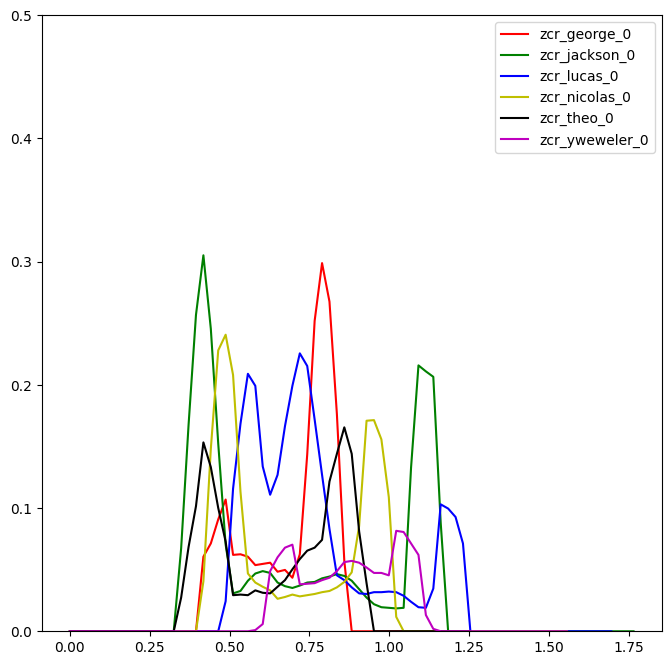

In [49]:
# zcr for not trimmed signals (means including silence)
zcr_george_0 = librosa.feature.zero_crossing_rate(audio[0].get_signal())[0] 
zcr_jackson_0 = librosa.feature.zero_crossing_rate(audio[50].get_signal())[0] 
zcr_lucas_0 = librosa.feature.zero_crossing_rate(audio[100].get_signal())[0] 
zcr_nicolas_0 = librosa.feature.zero_crossing_rate(audio[150].get_signal())[0] 
zcr_theo_0 = librosa.feature.zero_crossing_rate(audio[200].get_signal())[0] 
zcr_yweweler_0 = librosa.feature.zero_crossing_rate(audio[250].get_signal())[0]
t1 = librosa.frames_to_time(range(len(zcr_george_0)))
t2 = librosa.frames_to_time(range(len(zcr_jackson_0)))
t3 = librosa.frames_to_time(range(len(zcr_lucas_0)))
t4 = librosa.frames_to_time(range(len(zcr_nicolas_0)))
t5 = librosa.frames_to_time(range(len(zcr_theo_0)))
t6 = librosa.frames_to_time(range(len(zcr_yweweler_0)))
plt.figure(figsize=(8,8))
plt.plot(t1, zcr_george_0, color="r", label="zcr_george_0")
plt.plot(t2, zcr_jackson_0, color="g", label="zcr_jackson_0")
plt.plot(t3, zcr_lucas_0, color="b", label="zcr_lucas_0")
plt.plot(t4, zcr_nicolas_0, color="y", label="zcr_nicolas_0")
plt.plot(t5, zcr_theo_0, color="k", label="zcr_theo_0")
plt.plot(t6, zcr_yweweler_0, color="m", label="zcr_yweweler_0")
plt.ylim((0,0.5))
plt.legend()
plt.show()

* `Mel-spectrogram` : A Mel-spectrogram, also known as a Mel-frequency spectrogram, is a frequency domain audio feature that is representation of the short-term power spectrum of an audio signal, where the frequency axis is scaled according to the Mel scale, which is a perceptual scale of pitches. Here's an explanation of how a Mel-spectrogram is computed:

    1. The audio signal is typically divided into short overlapping frames using techniques such as the Short-Time Fourier Transform (STFT). Each frame represents a short segment of the signal.

    2. The power spectrum of each frame is computed using the Fourier Transform. This represents the distribution of signal energy across different frequencies. The resulting power spectrum is then transformed from the linear frequency scale to the Mel scale using a Mel filterbank (the Mel filterbank consists of a set of triangular filters spaced uniformly on the Mel scale. These filters are designed to mimic the frequency response of the human auditory system).
    
    3. After filtering, the magnitude values are typically logarithmically compressed using the logarithm function. This enhances the contrast between low and high energy regions of the spectrum and better reflects human perception. Then the logarithmically compressed values are plotted as a function of time (frames) and frequency (Mel scale) to generate the Mel-spectrogram.

    Here are some plots of this feature from our dataset:

In [50]:
def show_mel_spectrogram(audio):
    mel_spectrogram = librosa.feature.melspectrogram(y = audio.get_trimmed_signal())
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel-spectrogram for 0_{audio.get_name()}")
    plt.tight_layout()
    plt.show()

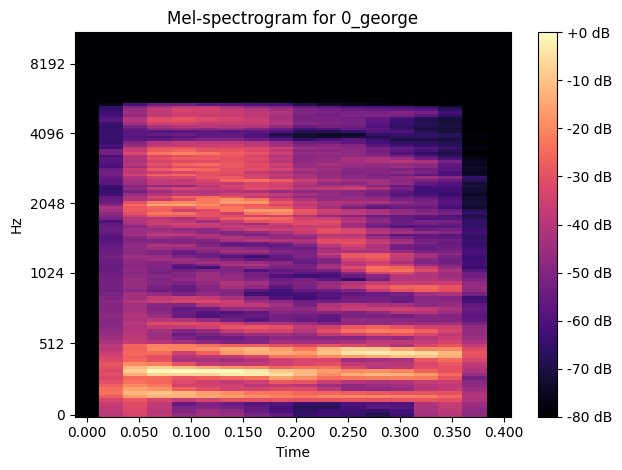

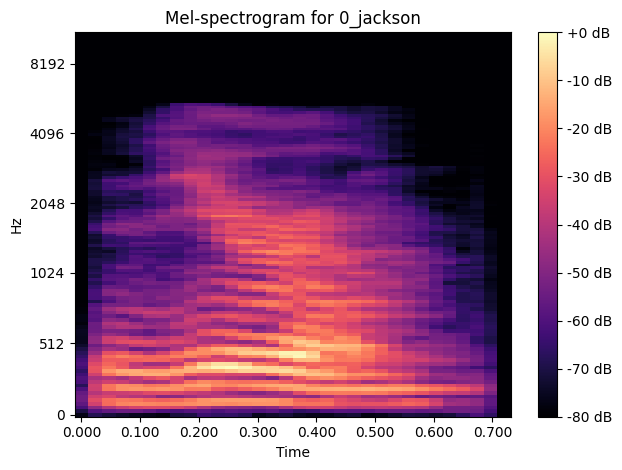

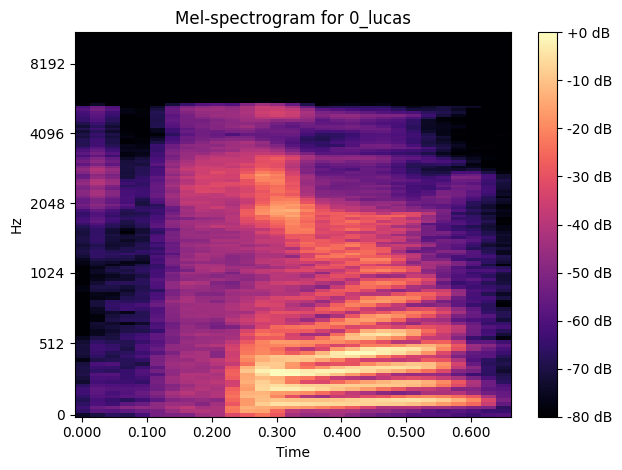

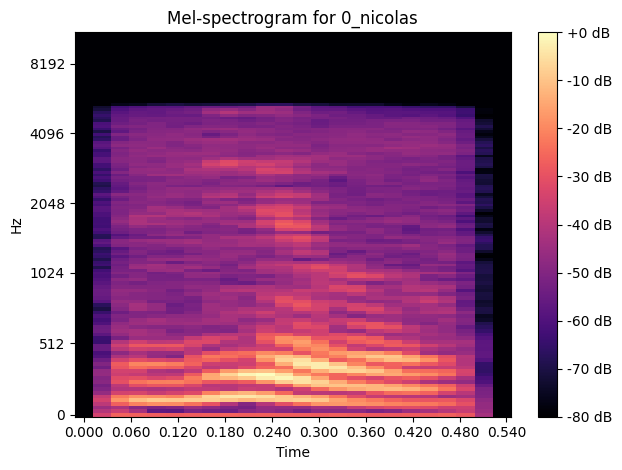

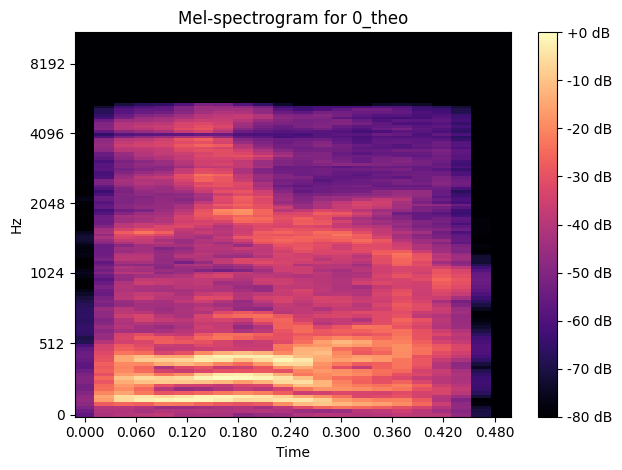

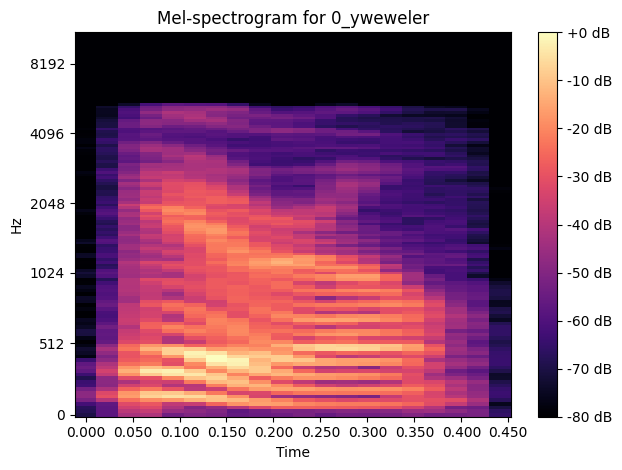

In [51]:
# I have showed the mel-spectrograms for trimmed signals (means that I have removed silence from start and end of voices)
show_mel_spectrogram(audio[0])
show_mel_spectrogram(audio[50])
show_mel_spectrogram(audio[100])
show_mel_spectrogram(audio[150])
show_mel_spectrogram(audio[200])
show_mel_spectrogram(audio[250])

* `Chroma Features` : Chroma features are primarily a representation in the frequency domain that represent the distribution of musical pitch (the perceived fundamental frequency of the sound) classes or chroma across time, providing information about the tonal content of the audio signal. It represent the presence or strength of each of the 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) in the musical octave (each pitch class corresponds to a particular note on the musical scale). The first step in computing chroma features involves estimating the pitch of the audio signal. Once the pitch is estimated, it is mapped onto the chroma circle, where each pitch class corresponds to an angle (0 to 11) around the circle. The resulting chroma vector represents the distribution of pitch classes in each frame of the audio signal.

    Here are some plots of this feature from our dataset:

In [52]:
def plot_chroma(audio):
    chroma = librosa.feature.chroma_stft(y=audio.get_trimmed_signal())
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm')
    plt.title(f'Chroma Features for 0_{audio.get_name()}')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

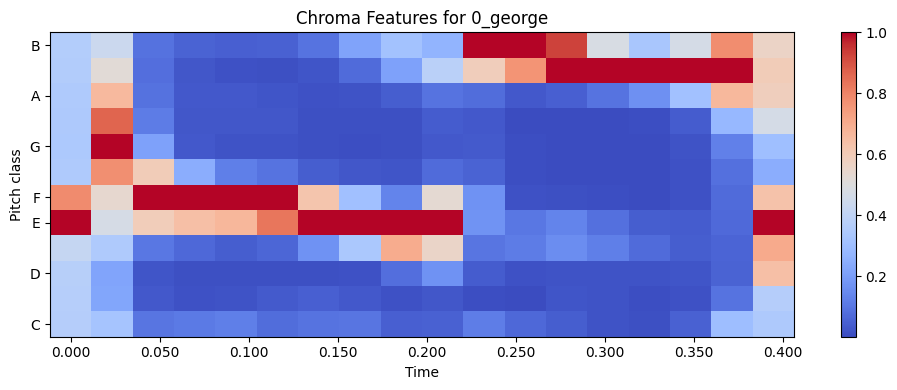

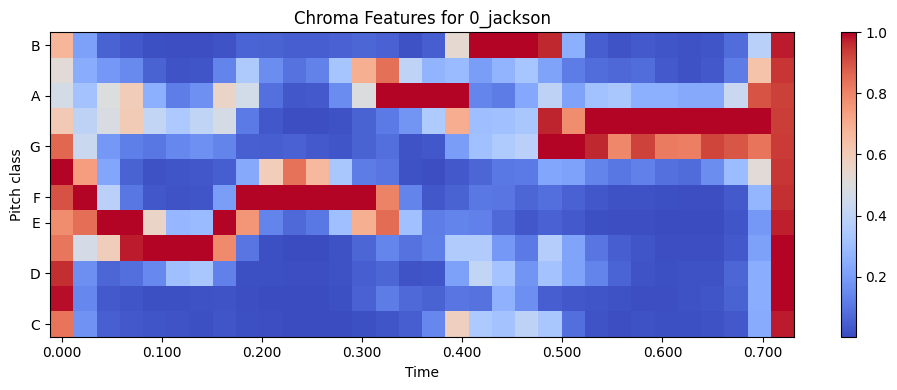

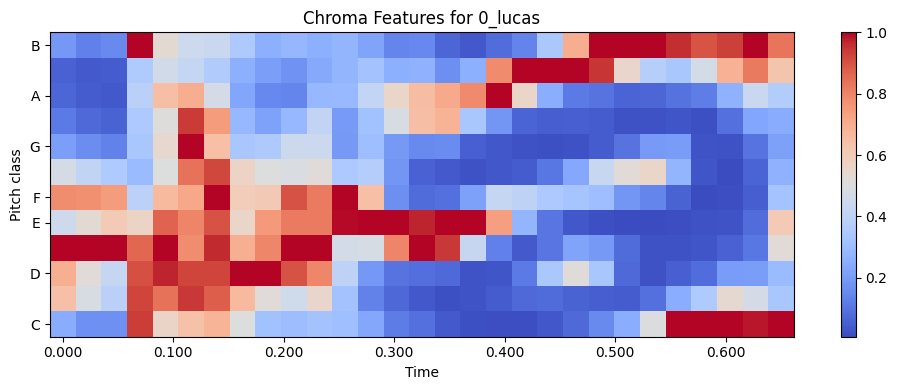

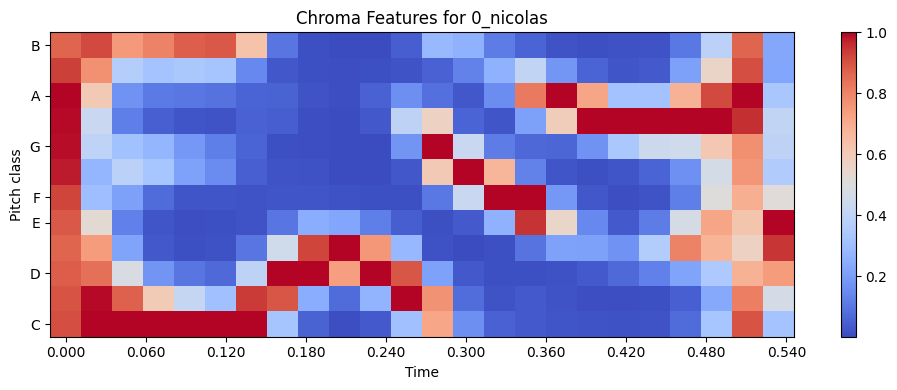

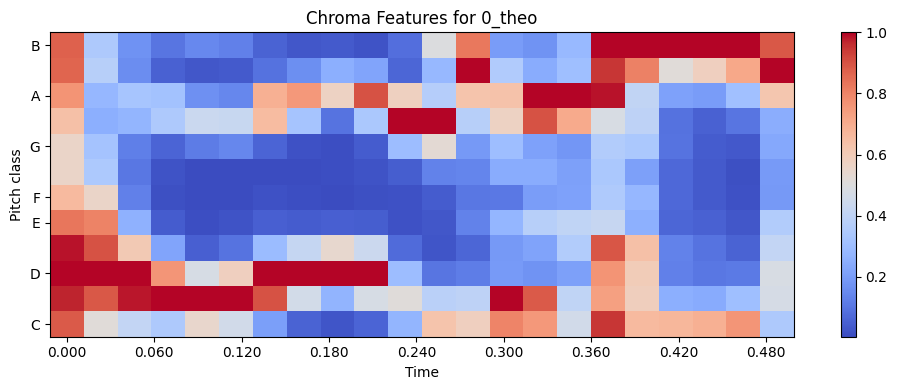

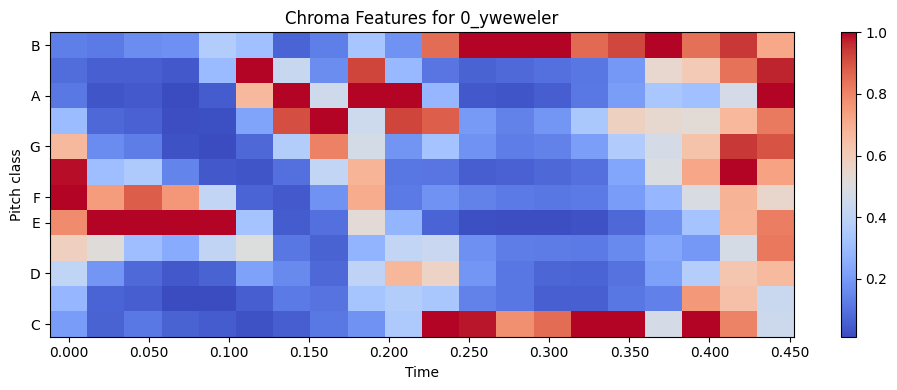

In [53]:
# I have showed the mel-spectrograms for trimmed signals (means that I have removed silence from start and end of voices)
plot_chroma(audio[0])
plot_chroma(audio[50])
plot_chroma(audio[100])
plot_chroma(audio[150])
plot_chroma(audio[200])
plot_chroma(audio[250])

* `MFCC` : Mel-Frequency Cepstral Coefficients (MFCCs) are a widely used feature extraction technique in audio signal processing and speech recognition. Here's an overview of MFCCs and how they are computed:

    1. The first step in computing MFCCs involves transforming the linear frequency scale of the audio signal into the Mel scale, which better represents the human perception of sound. This transformation is achieved using a series of triangular overlapping filters spaced uniformly on the Mel scale.

    2. After filtering, the magnitude values within each filter's bandwidth are typically logarithmically compressed to mimic the logarithmic response of the human auditory system to sound intensity.

    3. Once the Mel-frequency spectrogram is computed, it undergoes further processing using the Discrete Cosine Transform (the DCT is applied to the log-filterbank energies to decorrelate the features and emphasize important components). The resulting coefficients are known as Mel-Frequency Cepstral Coefficients (MFCCs).
    
    4. For the feature extraction part, typically a subset of the resulting MFCCs is selected for further analysis (I will explain the reason of this in question 6 in this part).

    Here are MFCCs for each speaker saying 0:

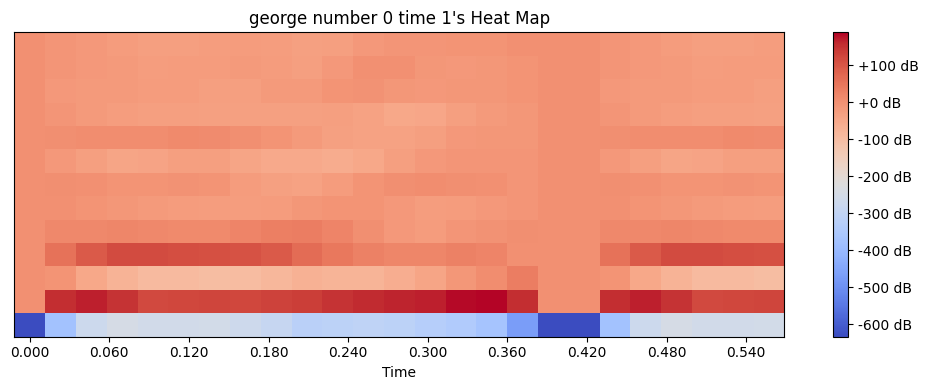

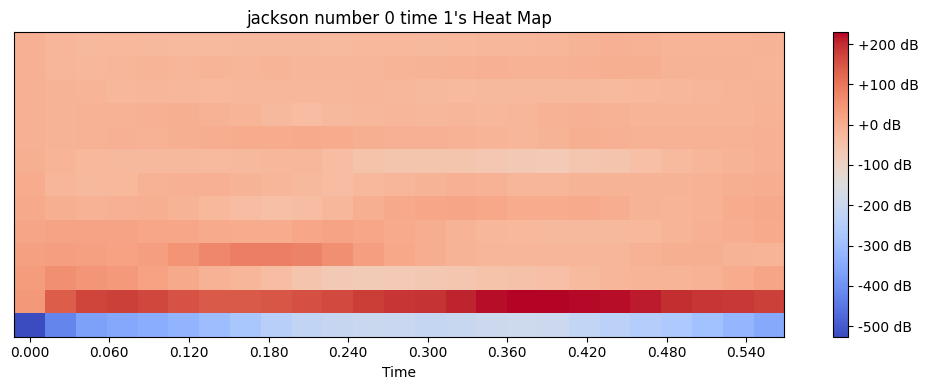

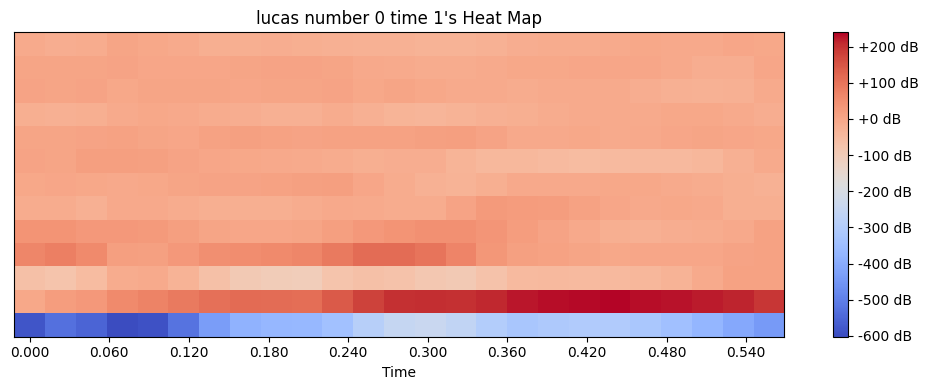

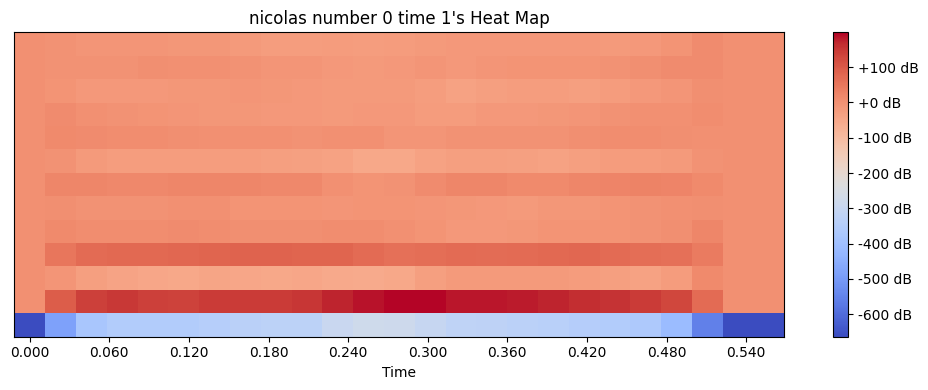

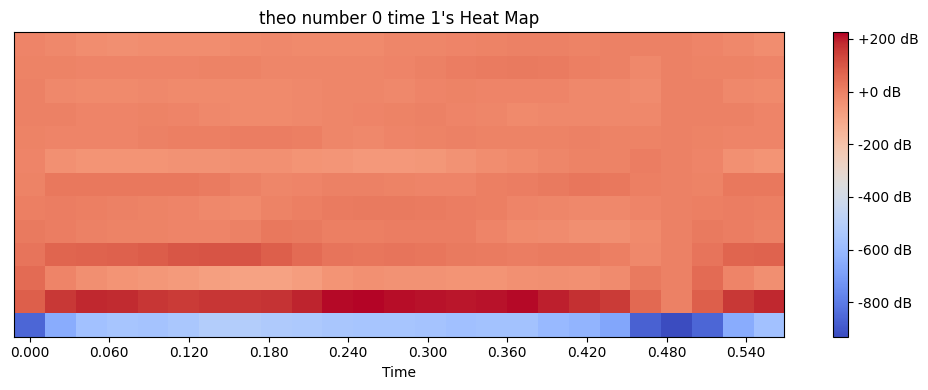

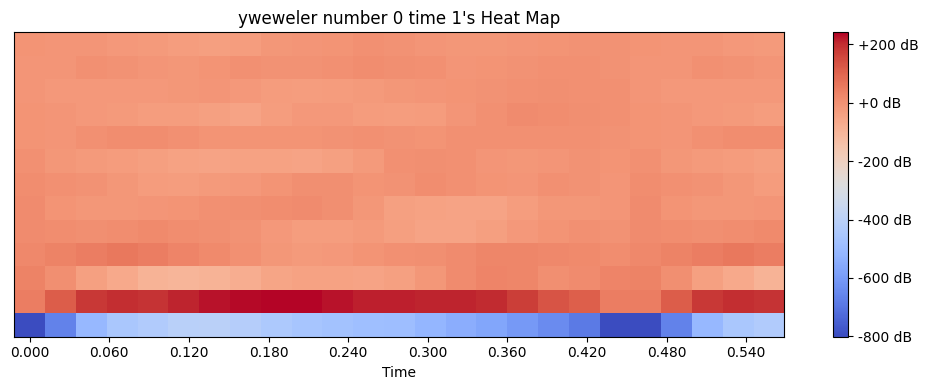

In [54]:
# I have showed the mfccs for trimmed signals (means that I have removed silence from start and end of voices)
show_mfccs_heat_map(audio[0])
show_mfccs_heat_map(audio[50])
show_mfccs_heat_map(audio[100])
show_mfccs_heat_map(audio[150])
show_mfccs_heat_map(audio[200])
show_mfccs_heat_map(audio[250])

As we can see, each of these features are in a specific domain that I have explained and each of them are used in some situations and models related to audio processing. However, the most complete features that many models are trained based on them are time-frequency features. Also, the most popular and effective feature in this group are MFCCs,hence I use MFCC as feature for training my model.

#### Question 3: Explain the robustness and sensitivity of properties of MFCCs to changes in audio signals.

1. **Robustness** : Robustness means that even if there are some changes or distractions in the background, MFCCs can still understand and describe the main sound we want to focus on.

2. **Sensitivity** : This is about how well MFCCs can pick up on subtle differences in sounds. Sensitivity is about how well MFCCs can notice the small differences and describe them accurately. It's like being able to tell the difference between two voices, even if they sound similar.

So MFCCs are good at ignoring background noise and focusing on the main sound we're interested in (robustness), and they are also good at noticing small differences in sounds and describing them accurately (sensitivity). This makes them really useful for understanding and working with audio signals in many kinds of situations.

#### Question 4 : Is there some special situations that MFCCs are less practical and less effective?
Yes. Here are some scenarios where MFCCs are less practical:
1. **Non-Stationary Signals** : MFCCs are typically computed over short-time frames, assuming that the signal is stationary within each frame. In cases where the signal is highly non-stationary or exhibits rapid changes over short time intervals, MFCCs may not capture temporal dynamics accurately.

2. **Transient Sounds**: MFCCs may not be well-suited for capturing transient sounds or short-duration events, as they are computed over relatively long analysis windows(mathematical functions that are applied to a segment of the audio signal before performing any analysis or processing). Transient sounds may not be often represented by the MFCCs computed from these windows.

3. **Highly Variable Acoustic Conditions** : While MFCCs are robust to certain types of acoustic variations, such as changes in overall signal amplitude or frequency content, they may struggle to handle highly variable acoustic conditions, such as extreme background noise.

4. **Complex Harmonic Structures** : In scenarios involving audio signals with complex harmonic structures, such as polyphonic music or sounds with overlapping harmonic components, MFCCs may not adequately capture the full complexity of the harmonic content.

#### Question 5 : In the calculation process of MFCCs, why do the frames have overlap with each other?
This is mainly because of capturing temporal dynamics and ensure a smooth transition between adjacent frames. Here are the reasons and benefits of this overlapping:

1. **Smoothing Effects** : Overlapping frames contribute to a smoother representation of the audio signal by averaging out short-term fluctuations and transient effects. This smoothing effect can help reduce the impact of noise or artifacts in the signal and produce more robust feature representations.

2. **Frame Rate Control** : By adjusting the amount of overlap between frames, the frame rate of the analysis can be effectively controlled. Overlapping frames allow for a higher frame rate while maintaining temporal coherence, which can be beneficial for capturing fast-changing spectral characteristics or fine temporal details.

3. **Redundancy Reduction** : Overlapping frames reduce the redundancy between adjacent frames by sharing information across time. Instead of analyzing each frame in isolation, overlapping frames allow for the integration of information from neighboring frames, which can improve the stability and reliability of feature extraction.

4. **Temporal Continuity** : Overlapping frames ensure that the analysis does not abruptly transition from one time window to the next. This temporal continuity helps maintain the integrity of time-varying features in the audio signal, such as transient sounds or evolving spectral characteristics.

#### Question 6 : Why in the most audio processing projects, only the first 12 or 13 coefficients of MFCCs are used?
Instead of talking about every tiny detail of the sound, we focus on just a few key features that are really important for understanding what the instrument sounds like. By using only the first 12 or 13 coefficients of MFCCs, we're essentially focusing on the most important aspects of the sound and ignoring some of the smaller details that might not matter as much. This simplified description of the sound is easier to work within computer programs because it's not too complicated, and it still gives us a good understanding of what the sound is like. Here are some more exact reasons of this from more scientific way:

1. **Dimensionality Reduction** : MFCCs are high-dimensional feature vectors, especially when computed with a large number of filter banks and cepstral coefficients. By selecting only the first 12 or 13 coefficients, the dimensionality of the feature space is reduced, making the subsequent processing steps more computationally efficient.

2. **Perceptual Relevance** : The first few MFCC coefficients capture the most perceptually relevant information about the spectral envelope of the audio signal. These coefficients are sensitive to changes in the overall spectral shape, which is often critical for tasks such as speech recognition, speaker identification, and audio classification.

3. **Robustness** : The first MFCC coefficients tend to be more robust to variations in acoustic conditions, such as changes in background noise, speaker characteristics, and channel distortions. By focusing on the most informative coefficients, the resulting feature representation is more resilient to such variations, leading to improved performance in practical applications.

4. **Data Compression** : The first few MFCC coefficients contain the main information about the spectral characteristics of the audio signal. By discarding higher-order coefficients, which may contain less informative information, the overall feature representation can be compressed without significant loss of discriminative power.

## *Part2 : Introduction to HMM*

## *Part2 Questions:*

#### Question 1 : What is the meaning of state and observation in an HMM model? What are the states in this project and how can we reach the observations?

In an HMM model, we have a set of observed variables (observations) and a set of hidden states. At each time, the observation of a variable from our observation set depends on the state (hidden state) that occurs at that time. Since the states can not be observed directly at each time, we should train our model in order to learn about the state at a particular time based on our observations until now and the previous state (due to hidden markov model property). In the conclusion, we can say that we can't see a state at each time but we can see it's effect (observation) and train our model based on that.

In this project, since we have two different set of target variables (digit and speaker name), the states can be different in these two. However, in this dataset and problem, the states are mainly depend on the voice, language, tone, intensity, melody and other aspects and properties of the sound of speaker that says the number. So there is not a specified number of states in this problem but we can make our model better by increasing the number of states in order to make a better prediction of what the speaker has said or who has said it. Because of that, I have defined two hyper-parameters as `NUM_OF_HIDDEN_STATES_NUMBERS` and `NUM_OF_HIDDEN_STATES_SPEAKERS` in order to reach a better prediction.

Also, the observations in this project are the features that we extract from voices which in this case are MFCCs.

#### Question 2 : We can classify HMM models based on the dependencies between hidden sates. What is a First-Order HMM and what are the differences between this and other classes based on this classification? 

A First-Order HMM is an HMM model that the probability of current observation (at time t) is only depend on the previous observation, means that based on bayes' net rule, current observation is independent from all past obsevations given current state and this gives a big advantage to us as if we don't need to know about all the past events to make predictions about the future. We have higher oreder markov chains too. For example, for a second-order Markov chain, probability of an observation at time t depends on **two** preceding ones.

#### Question 3 : Investigate about HMM and tell for modeling which problems does is suitable for?

HMMs are suitable for modeling problems that involve sequences of observations or events. Here are some problems which HMMs are suitable for:



1. **Analyzing Texts (Natural Language Processing (NLP))**: They are used in language processing to understand and analyze texts or conversations. In these applications, the observed data are sequences of words or tokens, and the hidden states represent grammatical categories, semantic labels, or syntactic structures.

2. **Understanding Speech (Speech Recognition)** : HMMs help computers understand what people are saying by looking at the sounds in speech and extracting audio features as observations (like this project).

3. **Recognizing Gestures**: HMMs are used to recognize hand movements or other gestures people make. In these problems, the hidden states represent different gestures.

4. **Predicting Stock Markets** : In finance, HMMs help predict the changes in stock prices. In this context, the observed data are sequences of financial prices and the hidden states represent different market organizations.   

5. **Studying Genes (Bioinformatics)** : Scientists use HMMs to study DNA and figure out how genes work. In bioinformatics, the observed data typically consist of sequences of amino acids. Also the hidden states represent structural elements and functional domains.


So HMMs are very useful for sequences of events. They are useful in situations where we are trying to understand or predict what is going to happen next based on what we have seen so far (especially suitable for modeling problems with sequential data).

#### Question 4 : Investigate about advantages and disadvantages of HMM model and explain each briefly.

* `Advantages` :

    1. **Sequential Data Handling** : HMMs are well-suited for sequential data, where the order of observations matters. They can model temporal dependencies effectively.

    2. **Compact Representation** : HMMs represent complex systems with a relatively small number of parameters. The transition probabilities and emission probabilities encode the system’s behavior.

    3. **Efficient and Scalable** : The markov property  reduces the computational complexity of inference and learning. 

    4. **Efficient Inference** : Algorithms like the Viterbi algorithm and the forward-backward algorithm allow efficient computation of the most likely sequence of hidden states and the likelihood of observations.

    5. **Memory Efficiency** : HMMs require relatively small memory compared to other complex models, making them suitable for real-time applications and devices with limited computational resources.

* `Disadvantages` : 

    1. **Unstructured Parameters** : HMMs often have a large number of unstructured parameters, which can lead to overfitting if not handled carefully.

    2. **Limited Expressiveness** : First-order HMMs cannot express direct dependencies between hidden states. They lack the ability to capture higher-order dependencies between the states.

    3. **Markovian Assumption** : HMMs assume that future states depend only on the current state (first-order Markov property). This may not always hold in complex systems where long-term dependencies exist(like in bioinformatics that deals with DNAs).

    4. **Computational Complexity** : As the number of states increases, HMMs can become computationally expensive because of the need to compute probabilities for all possible state sequences.

#### Question 5 : Investigate about different kinds of HMMs and explain each briefly.

1. **Traditional HMM** : The HMM that we learned about in this lecture and used in this project (first-order HMM).

2. **Switching HMM** : A switching HMM is an extension of the traditional HMM that allows for modeling changes in underlying states or behaviors over time. Switching HMMs provide a flexible framework for capturing dynamic changes in behavior, making them valuable in various fields where underlying states switch over time. They are commonly used in eye-tracking studies to model transitions between exploration and preference-biased periods.

3. **Left-to-Right HMM** : Left-to-Right HMMS form an essential subclass of HMMs used for modeling time series data(especially in scenarios where transitions occur in a specific order2). These models are often used in temporal sequence modeling, such as modeling the progression of phonemes in speech recognition.

4. **Factorial HMM** : In Factorial HMMs, this hidden state is factored into multiple state variables, resulting in a distributed representation. Each state variable captures different aspects of the underlying process. Factorial HMMs involve multiple independent Markov chains of latent variables. They find applications in various fields where multiple interacting processes influence observations.

5. **Ergodic HMM** : An Ergodic HMM is a type of HMM where transitions between emitting states are fully connected. In other words, any emitting state can transition to any other emitting state. The other aspect of this HMM is versatility, means that they are not constrained by a specific order of state transitions. Ergodic HMMs provide a powerful framework for modeling complex dependencies in sequential data, allowing transitions between any emitting state.

6. **Continuous-time HMM** : Continuous-time HMM extends the concept of HMM to situations where time flows continuously, rather than in discrete steps. In Continuous-time HMMs, measurements and state changes can happen at any point, not just at fixed intervals. Continuous-time HMMs assume that during small time intervals, the probability of a state change is also small. So the state transition probability matrix is close to a unit matrix for small intervals. These kind of HMMs are used in signal processing, speech and image recognition and finance.


## *Part3 : Implementation with library*

In this part, we will make our model with the use of `hmmlearn` library and test it with our test data. Here are an explanation of functions of this part:

* `make_models()` : This function makes our models based on the input (numbers' models or speakers' models).

* `predict_model()` : This function does the prediction part with the test data. It returns the predicted values and true values.

* `produce_confusion_matrix()` : This function produces the confusion matrix from predicted values and true values.

* `create_heat_map()` : This function creates heat map for visualizing the confusion matrix using seaborn library.

* `calc_accuracy_class()` : This function calculates the accuracy parameter for evaluating a class prediction performance.

* `calc_precision_class()` : This function calculates the precision parameter for evaluating a class prediction performance.

* `calc_recall_class()` : This function calculates the recall parameter for evaluating a class prediction performance.

* `calc_f1score_class()` : This function calculates the f1score parameter for evaluating a class prediction performance.

* `calc_total_accuracy()` : This function calculates the total accuracy parameter for evaluating whole model prediction performance.

* `create_metrics_heatmap()` : This function produce a heatmap for better visualizing the performance parameters for the model.

In [55]:
def make_models(trained_model, n):
    models = dict()
    for key in trained_model:
        trained_list = trained_model[key].T
        hmm_model = hmm.GaussianHMM(n_components = n)
        hmm_model.fit(trained_list)
        models[key] = hmm_model
    return models

In [56]:
def predict_model(test, models):
    predicts = []
    true_values = []
    for x in test:
        temp = []
        for i in range(len(test[x])):
            transp = test[x][i].T
            argmax = None
            max_score = -math.inf
            # Test each model based on the hmm model that has been prepared
            # and provide the maximum score as the model prediction
            for key in models:
                model = models[key]
                score = model.score(transp)
                if(score > max_score):
                    argmax = key
                    max_score = score
            temp.append(argmax)
        predicts.extend(temp)
        true_values.extend([x] * len(test[x]))
    return true_values, predicts

In [57]:
def produce_confusion_matrix(true_values, predicts):
    labels = sorted(set(predicts + true_values))
    num_classes = len(labels)
    confusion_matrix = [[0] * num_classes for _ in range(num_classes)]
    for pred, tru in zip(predicts, true_values):
        row_index = labels.index(tru)
        col_index = labels.index(pred)
        confusion_matrix[row_index][col_index] += 1
    return confusion_matrix

In [58]:
def create_heat_map(labels, confusion_matrix, color):
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap=color, fmt='.0f')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [59]:
def create_metrics_heatmap(labels, metrics, confusion_matrix, color):
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix, annot=True, xticklabels=labels, yticklabels=metrics, cmap=color, fmt='.2f')
    plt.xlabel("Labels")
    plt.ylabel("Measurements")
    plt.show()

In [60]:
def calc_accuracy_class(confusion_matrix, class_idx):
    TP = confusion_matrix[class_idx, class_idx]
    TN = np.sum(np.delete(np.delete(confusion_matrix, class_idx, axis=0), class_idx, axis=1))
    TP_TN_FP_FN = np.sum(confusion_matrix)
    accuracy = (TP + TN) / TP_TN_FP_FN
    return accuracy

In [61]:
def calc_precision_class(confusion_matrix, class_idx):
    TP = confusion_matrix[class_idx, class_idx]
    FP = np.sum(confusion_matrix[:, class_idx]) - TP
    if TP + FP == 0:
        return 0
    precision = TP / (TP + FP)
    return precision

In [62]:
def calc_recall_class(confusion_matrix, class_idx):
    TP = confusion_matrix[class_idx, class_idx]
    FN = np.sum(confusion_matrix[class_idx, :]) - TP
    if TP + FN == 0:
        return 0
    recall = TP / (TP + FN)
    return recall

In [63]:
def calc_f1score_class(confusion_matrix, class_idx):
    recall = calc_recall_class(confusion_matrix, class_idx)
    precision = calc_precision_class(confusion_matrix, class_idx)
    if precision + recall== 0:
        return 0
    return 2 * ((recall * precision) / (recall + precision))

In [64]:
def calc_total_accuracy(confusion_matrix):
    TPs = np.sum(np.diag(confusion_matrix))
    total = np.sum(confusion_matrix)
    total_acc = TPs / total
    return total_acc

In [65]:
def calc_measurements(confusion_matrix, labels):
    precisions = []
    recalls = []
    f1scores = []
    accuracy = []
    measurements = ["F1 Score", "Recall", "Precision", "Accuracy"]
    for i in range(len(labels)):
        precisions.append(calc_precision_class(confusion_matrix,i))
        recalls.append(calc_recall_class(confusion_matrix,i))
        f1scores.append(calc_f1score_class(confusion_matrix,i))
        accuracy.append(calc_accuracy_class(confusion_matrix,i))
        print(f'Accuracy for class "{labels[i]}" : {accuracy[i]}')
        print(f'Precision for class "{labels[i]}" : {precisions[i]}')
        print(f'Recall for class "{labels[i]}" : {recalls[i]}')
        print(f'F1 score for class "{labels[i]}" : {f1scores[i]}')
        print("------")
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1scores = np.array(f1scores)
    accuracy = np.array(accuracy)
    print(f"Recalls average(macro-average) : {np.mean(recalls)}")
    print(f"F1 scores average(macro-average) : {np.mean(f1scores)}")
    print(f"Precisions average(macro-average) : {np.mean(precisions)}")
    print(f"Total accuracy : {calc_total_accuracy(confusion_matrix)}")
    all_measurements = np.array([f1scores, recalls, precisions, accuracy])
    create_metrics_heatmap(labels, measurements, all_measurements, "cividis")

In [66]:
labels = [str(i) for i in range(0, 10)]
hmm_numbers_models = make_models(numbers_dict_train, NUM_OF_HIDDEN_STATES_NUMBERS)
true, pred = predict_model(numbers_dict_test, hmm_numbers_models)
confusion_matrix = produce_confusion_matrix(true, pred)
confusion_matrix = np.array(confusion_matrix)

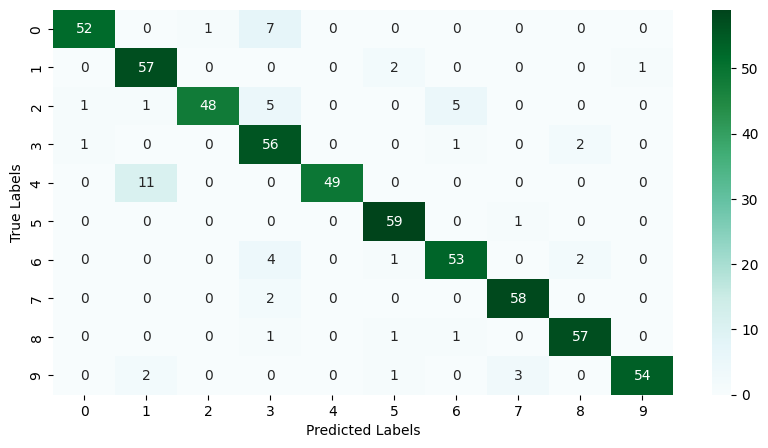

In [67]:
create_heat_map(labels,confusion_matrix,"BuGn")

Accuracy for class "0" : 0.9833333333333333
Precision for class "0" : 0.9629629629629629
Recall for class "0" : 0.8666666666666667
F1 score for class "0" : 0.912280701754386
------
Accuracy for class "1" : 0.9716666666666667
Precision for class "1" : 0.8028169014084507
Recall for class "1" : 0.95
F1 score for class "1" : 0.8702290076335878
------
Accuracy for class "2" : 0.9783333333333334
Precision for class "2" : 0.9795918367346939
Recall for class "2" : 0.8
F1 score for class "2" : 0.8807339449541285
------
Accuracy for class "3" : 0.9616666666666667
Precision for class "3" : 0.7466666666666667
Recall for class "3" : 0.9333333333333333
F1 score for class "3" : 0.8296296296296296
------
Accuracy for class "4" : 0.9816666666666667
Precision for class "4" : 1.0
Recall for class "4" : 0.8166666666666667
F1 score for class "4" : 0.8990825688073394
------
Accuracy for class "5" : 0.99
Precision for class "5" : 0.921875
Recall for class "5" : 0.9833333333333333
F1 score for class "5" : 0.9

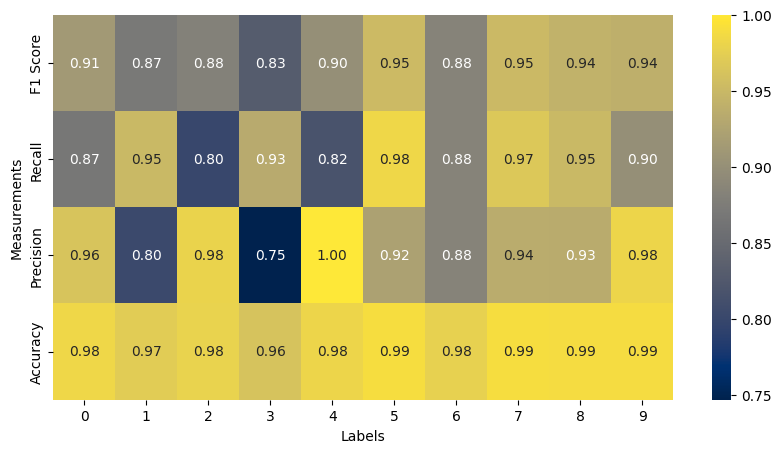

In [68]:
calc_measurements(confusion_matrix, labels)

In [69]:
labels_s = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]
hmm_speakers_models = make_models(speakers_dict_train, NUM_OF_HIDDEN_STATES_SPEAKERS)
true_s, pred_s = predict_model(speakers_dict_test, hmm_speakers_models)
confusion_matrix_s = produce_confusion_matrix(true_s, pred_s)
confusion_matrix_s = np.array(confusion_matrix_s)

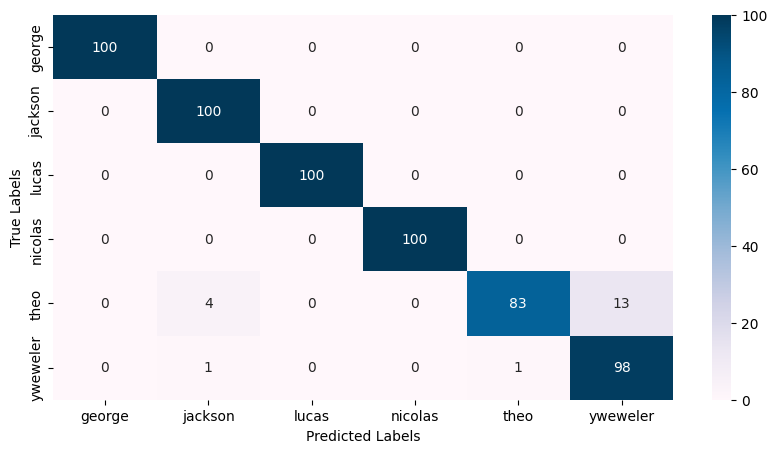

In [70]:
create_heat_map(labels_s,confusion_matrix_s,"PuBu")

Accuracy for class "george" : 1.0
Precision for class "george" : 1.0
Recall for class "george" : 1.0
F1 score for class "george" : 1.0
------
Accuracy for class "jackson" : 0.9916666666666667
Precision for class "jackson" : 0.9523809523809523
Recall for class "jackson" : 1.0
F1 score for class "jackson" : 0.975609756097561
------
Accuracy for class "lucas" : 1.0
Precision for class "lucas" : 1.0
Recall for class "lucas" : 1.0
F1 score for class "lucas" : 1.0
------
Accuracy for class "nicolas" : 1.0
Precision for class "nicolas" : 1.0
Recall for class "nicolas" : 1.0
F1 score for class "nicolas" : 1.0
------
Accuracy for class "theo" : 0.97
Precision for class "theo" : 0.9880952380952381
Recall for class "theo" : 0.83
F1 score for class "theo" : 0.9021739130434783
------
Accuracy for class "yweweler" : 0.975
Precision for class "yweweler" : 0.8828828828828829
Recall for class "yweweler" : 0.98
F1 score for class "yweweler" : 0.9289099526066351
------
Recalls average(macro-average) : 0.

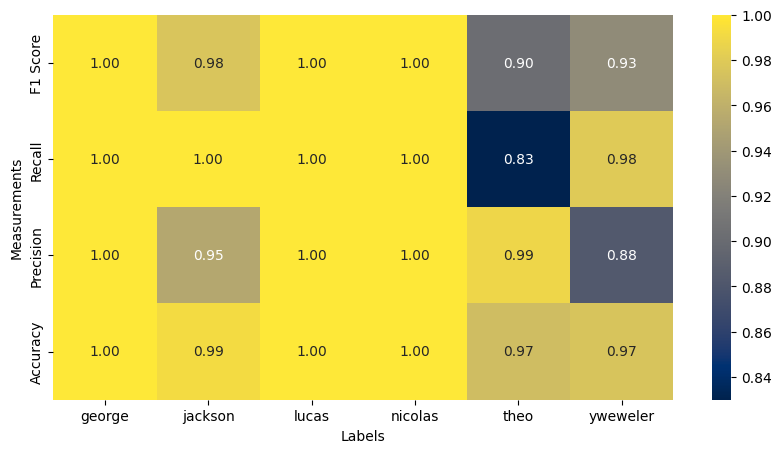

In [71]:
calc_measurements(confusion_matrix_s, labels_s)

## *Part4 : Implementation from scratch*

In this part, we are going to implement our HMM model and attributes. As the necessary explanations about the attributes of this class are given in the description of the project, I am not going to explain them again.

In [72]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, 0] = (observation_matrix[:, 0]) * (self.initial_prob.flatten())
            else:
                alpha[:, t] = (observation_matrix[:, t]) * (self._normalize(np.dot(self.transition_matrix.T, alpha[:, t-1])))
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = self._normalize(np.dot(self.transition_matrix, observation_matrix[:, t+1] * beta[:, t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = scipy.stats.multivariate_normal.pdf(obs.T, mean=self.mean[:, s].T, cov=self.covariances[:, :, s].T)
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = (self.transition_matrix) * (np.outer(alpha[:, t], beta[:, t + 1]) * B[:, t + 1])
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0]
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

In [73]:
hmm_models_p2 = {}
for key in numbers_dict_train:
    model = HMM(num_hidden_states=NUM_OF_HIDDEN_STATES_NUMBERS) 
    model.train(numbers_dict_train[key], num_iterations=10)
    hmm_models_p2[key] = model

In [74]:
predicts = []
true_values = []
for x in numbers_dict_test:
    temp = []
    for i in range(len(numbers_dict_test[x])):
        argmax = None
        max_score = -math.inf
        for key in hmm_models_p2:
            model = hmm_models_p2[key]
            score = model.score(numbers_dict_test[x][i])
            if(score > max_score):
                argmax = key
                max_score = score
        temp.append(argmax)
    predicts.extend(temp)
    true_values.extend([x] * len(numbers_dict_test[x]))

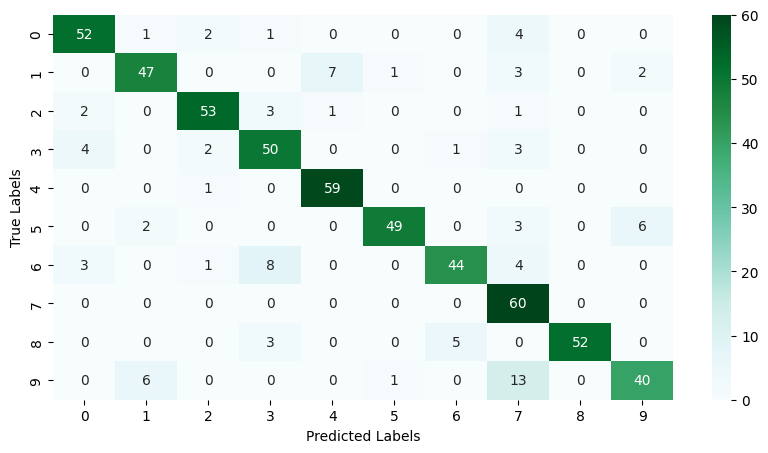

In [75]:
confusion_matrix_p2 = produce_confusion_matrix(true_values, predicts)
confusion_matrix_p2 = np.array(confusion_matrix_p2)
create_heat_map(labels,confusion_matrix_p2,"BuGn")

Accuracy for class "0" : 0.9716666666666667
Precision for class "0" : 0.8524590163934426
Recall for class "0" : 0.8666666666666667
F1 score for class "0" : 0.8595041322314049
------
Accuracy for class "1" : 0.9633333333333334
Precision for class "1" : 0.8392857142857143
Recall for class "1" : 0.7833333333333333
F1 score for class "1" : 0.8103448275862069
------
Accuracy for class "2" : 0.9783333333333334
Precision for class "2" : 0.8983050847457628
Recall for class "2" : 0.8833333333333333
F1 score for class "2" : 0.8907563025210085
------
Accuracy for class "3" : 0.9583333333333334
Precision for class "3" : 0.7692307692307693
Recall for class "3" : 0.8333333333333334
F1 score for class "3" : 0.8
------
Accuracy for class "4" : 0.985
Precision for class "4" : 0.8805970149253731
Recall for class "4" : 0.9833333333333333
F1 score for class "4" : 0.9291338582677166
------
Accuracy for class "5" : 0.9783333333333334
Precision for class "5" : 0.9607843137254902
Recall for class "5" : 0.8166

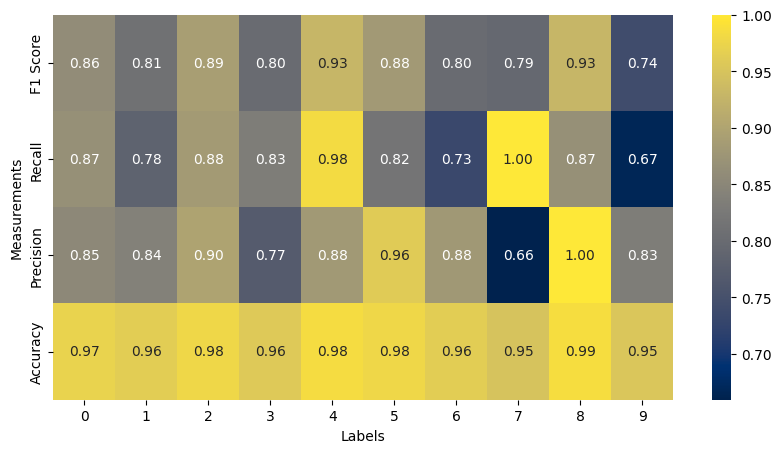

In [76]:
calc_measurements(confusion_matrix_p2, labels)

In [77]:
hmm_models_p2_speakers = {}
for key in speakers_dict_train:
    model = HMM(num_hidden_states=NUM_OF_HIDDEN_STATES_SPEAKERS) 
    model.train(speakers_dict_train[key], num_iterations=10)
    hmm_models_p2_speakers[key] = model

In [78]:
predicts_s = []
true_values_s = []
for x in speakers_dict_test:
    temp = []
    for i in range(len(speakers_dict_test[x])):
        argmax = None
        max_score = -math.inf
        for key in hmm_models_p2_speakers:
            model = hmm_models_p2_speakers[key]
            score = model.score(speakers_dict_test[x][i])
            if(score > max_score):
                argmax = key
                max_score = score
        temp.append(argmax)
    predicts_s.extend(temp)
    true_values_s.extend([x] * len(speakers_dict_test[x]))

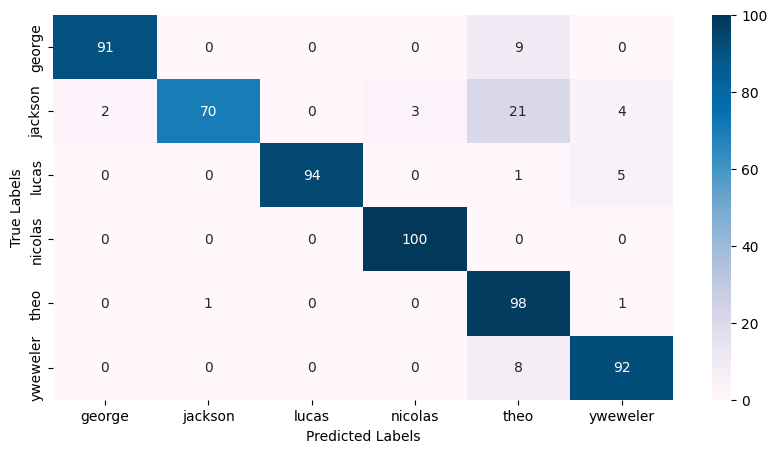

In [79]:
confusion_matrix_p2_speakers = produce_confusion_matrix(true_values_s, predicts_s)
confusion_matrix_p2_speakers = np.array(confusion_matrix_p2_speakers)
create_heat_map(labels_s,confusion_matrix_p2_speakers,"PuBu")

Accuracy for class "george" : 0.9816666666666667
Precision for class "george" : 0.978494623655914
Recall for class "george" : 0.91
F1 score for class "george" : 0.9430051813471503
------
Accuracy for class "jackson" : 0.9483333333333334
Precision for class "jackson" : 0.9859154929577465
Recall for class "jackson" : 0.7
F1 score for class "jackson" : 0.8187134502923976
------
Accuracy for class "lucas" : 0.99
Precision for class "lucas" : 1.0
Recall for class "lucas" : 0.94
F1 score for class "lucas" : 0.9690721649484536
------
Accuracy for class "nicolas" : 0.995
Precision for class "nicolas" : 0.970873786407767
Recall for class "nicolas" : 1.0
F1 score for class "nicolas" : 0.9852216748768473
------
Accuracy for class "theo" : 0.9316666666666666
Precision for class "theo" : 0.7153284671532847
Recall for class "theo" : 0.98
F1 score for class "theo" : 0.8270042194092827
------
Accuracy for class "yweweler" : 0.97
Precision for class "yweweler" : 0.9019607843137255
Recall for class "ywe

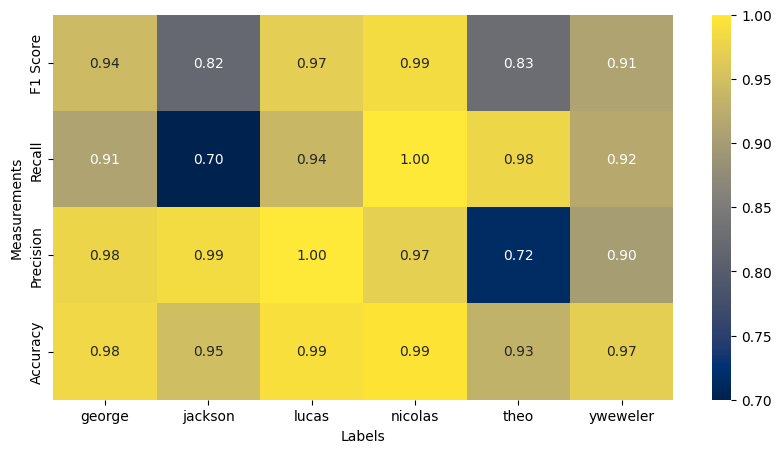

In [80]:
calc_measurements(confusion_matrix_p2_speakers, labels_s)

## *Part5 : Evaluation and Analysis*

## *Part3 and Part4 and Part5 Questions:*

#### Question 1 : There are 4 main criterias for evaluating the model performance. Explain each of them with it's formula.

First let me explain 4 different outputs produced by a machine learning algorithm:

* `TP` : The true value of the test is correctly classified true by the model.
* `TN` : The false value of the test is correctly classified false by the model.
* `FP` : The flase value of the test is wrongly classified true by the model.
* `FN` : The true value of the test is wrongly classified false  by the model.

Based on these 4 parameters, there are 4 metrics that we can evaluate our model performance based on them:

1. **Accuracy** : Accuracy represents the number of correctly classified data instances over the total number of data instances. The formula for calculating it is:
$$Accuracy = \frac{TN + TP}{TN+TP+FP+FN}$$

2. **Precision** : Precision represents TPs over TPs plus FPs. The formula for calculating it is:
$$Precision = \frac{TP}{TP+FP}$$

3. **Recall** : Recall represents TPs over TPs plus FNs. The formula for calculating it is:
$$Recall = \frac{TP}{TP+FN}$$

4. **F1 Score** : F1 score is a metric which takes into account both precision and recall. The formula for calculating it is:
$$F1 score= 2*\frac{Precision * Recall}{Precision + Recall}$$


#### Question 2 : Is there any problem for calculating these 4 metrics for this project that has multi-class classification? If yes, how can we solve it?

Yes this is a problem. The formulas that have been provided in the previous question are for a binary class model, which means it has only two classes. However, in our problem we have two different target variables which for numbers, we have 10 classes (0 to 9) and for speakers, we have 6 classes (6 speakers). So we are dealing with a multi-class problem and we can't use the same formulas. Here are two solutions that we can provide in order to solve this:

1. We can use each metric for each class separately. However, it is not very common to calculate accuracy for each class because it gives us a not appropriate and not exact overview of our model (I have calculated this for my classes in my model too in order to see that it is very different from other metrics and not appropriate). Instead, we will use total accuracy for multi-class classifications that is a good metric. The formulas for each of them are like below (each metric is for $ class_i$):

$$Accuracy_{class_i} = \frac{TN_{class_i} + TP_{class_i}}{TN_{class_i}+TP_{class_i}+FP_{class_i}+FN_{class_i}}$$


$$Precision_{class_i} = \frac{TP_{class_i}}{TP_{class_i}+FP_{class_i}}$$

$$Recall_{class_i} = \frac{TP_{class_i}}{TP_{class_i}+FN_{class_i}}$$

$$F1 score_{class_i}= 2*\frac{Precision_{class_i} * Recall_{class_i}}{Precision_{class_i} + Recall_{class_i}}$$

After this, we can compare different classes form their own parameters to others.

2. We can use some more overall metrics to evalute our whole multi-class model. These metrics are:

* `Total Accuracy` : This is the total accuracy of our model and it simply calculates all correct predictions over all predictions among all classes.

* `Averaging precision and recall` : Instead of having those many metrics for every class, we can reduce it to one “average” metric. However, there are differences in how we can implement it. The two popular approaches are macro-averaging and micro-averaging.
    1. **Macro-Averaging** : Average the precision and recall across all classes to get the final macro-averaged precision and recall scores. Here are the formulas : 
    $$Precision_{macro} = \frac{\sum_{i=1}^{N}Precision_{class_{i}}}{N}$$
    $$Recall_{macro} = \frac{\sum_{i=1}^{N}Recall_{class_{i}}}{N}$$

    2. **Micro-Averaging** : In this case, we apply the main formulas for recall and precision but with all TPs,FPs and FNs of all classes. The formulas will be like below :
    $$Precision_{micro} = \frac{\sum_{i=1}^{N}TP_{class_{i}}}{\sum_{i=1}^{N}TP_{class_{i}} +\sum_{i=1}^{N}FP_{class_{i}}}$$
    $$Recall_{micro} = \frac{\sum_{i=1}^{N}TP_{class_{i}}}{\sum_{i=1}^{N}TP_{class_{i}} +\sum_{i=1}^{N}FN_{class_{i}}}$$

    Each of these two approches are good for evaluating our model and each gives us some specific oversights about our model that I will explain in the next question.

#### Question 3 : How does each of the metrics evaluate our model?

1. **Precision** : Precision for a given class in multi-class classification is the fraction of instances correctly classified as belonging to a specific class out of all instances the model predicted to belong to that class. In other words, precision measures the model's ability to identify instances of a particular class correctly. Precision should ideally be 1 (high) for a good classifier. Precision becomes 1 only when the numerator and denominator are equal i.e TP = TP +FP, this also means FP is zero. As FP increases the value of denominator becomes greater than the numerator and precision value decreases (which we don’t want).

2. **Recall** : Recall in multi-class classification is the fraction of instances in a class that the model correctly classified out of all instances in that class. Recall should ideally be 1 (high) for a good classifier. Recall becomes 1 only when the numerator and denominator are equal i.e TP = TP +FN, this also means FN is zero. As FN increases the value of denominator becomes greater than the numerator and recall value decreases (which we don’t want).

3. **F1 Score** : The F1 score is a metric used to evaluate the performance of a classification model, particularly when dealing with imbalanced datasets. Ideally in a good classifier, we want both precision and recall to be one which also means FP and FN are zero. Therefore we need a metric that takes into account both precision and recall. F1-score is a metric which takes into account both precision and recall. F1 Score becomes 1 only when precision and recall are both 1. F1 score becomes high only when both precision and recall are high. F1 score is the harmonic mean of precision and recall.

4. **Accuracy** : Accuracy is a popular performance metric in classification problems. It measures the proportion of correctly classified cases from the total number of objects in the dataset. Accuracy is straightforward to interpret. However, accuracy has its downsides. While it does provide an estimate of the overall model quality, it disregards class balance and the cost of different errors.

5. **Macro-Averaging And Micro-Averaging** : Macro-averaging calculates each class's performance metric (e.g., precision, recall) and then takes the arithmetic mean across all classes. So, the macro-average gives equal weight to each class, regardless of the number of instances. Instead, micro-averaging aggregates the counts of true positives, false positives, and false negatives across all classes and then calculates the performance metric based on the total counts. So, the micro-average gives equal weight to each instance, regardless of the class label and the number of cases in the class. Micro-averaging can be more appropriate when you want to account for the total number of misclassifications in the dataset. It gives equal weight to each instance and will have a higher score when the overall number of errors is low. However, micro-averaging can also overemphasize the performance of the majority class, especially when it dominates the dataset. In this case, micro-averaging can lead to inflated performance scores when the classifier performs well on the majority class but badly on the minority classes. If the class is small, we might not notice.

So there is no single best metric. To choose the most suitable one, we need to consider the number of classes, their balance, and their relative importance. 

#### Question 4 : What is the difference between recall and precision and explain why each of them alone is not enough for evaluating the model? Give an example for each one that one of these two metrics are high but the performance of the model is not good.

As I have explain both precision and recall fully in previous questions, I will only say the difference between them. Recall measures the model's ability to correctly identify all positive instances while precision measures the accuracy of the model's positive predictions. In fact, to calculate the recall, we divide the number of correct predictions of $class_i$ by the total number of $class_i$ objects in the dataset (both identified and not). However, to calculate the precision, we divide the number of correct predictions of $class_i$ by the total number of $class_i$ predictions (true and false). So each one gives us a different overview of our model. Now I'm going to say two examples to determine it:

1. **High Precision and Low Recall** :  An email spam filter that rarely marks legitimate emails as spam (high precision), ensuring that our inbox is mostly free of false alarms. However, it also misses many actual spam emails (low recall), letting some slip through into our inbox and hence our model is not working good.

2. **High Recall and Low Precision** : A metal detector at an airport. If the detector has high recall but low precision, it will detect almost every object passing through it as metal, even though most of them are not. This means it's good at catching metal objects (high recall), but it also raises a lot of false alarms by mistakenly identifying non-metal objects as metal (low precision) and hence our model is not working good.


#### Question 5 : What type of mean is used in calculating f1 score?  What is the difference between this type of calculating mean and ordinary mean and why it is important in calculating f1 score?

The f1 score uses the harmonic mean in its calculation, not the ordinary mean. The main difference between the harmonic mean and the ordinary mean is how they handle extreme values. The harmonic mean gives more weight to smaller values, making it particularly sensitive to outliers or extreme values. This property is important in the context of the f1 score because it ensures that both precision and recall contribute equally to the final score. It is less sensitive to extremely large values (outliers). However, it does not ignore all outliers and extremely low values still have a significant influence on the result. The harmonic mean strikes a balance between precision and recall. In scenarios where both precision and recall are crucial, the f1 score provides a more informative assessment. It guides us toward a classifier that performs well across different classes, even when the dataset is imbalanced. If we look at the f1 scores for classes of models, we can find out that in the classes that recall and precision differ a lot, f1 score correctly guides us to the appropriate measurement of our model.

#### Question 6 : Train your model based on the numbers. Plot the confusion matrix and calculate precision and accuracy and then analize them.

I have trained my model with library (part3) and from scratch (part 4) and I have made their confusion matrix (the green ones with 60 tests for each number) and calculated the metrics for them in their section for each two part (part 3 and 4). Now I'm going to analize them based on total accuracy and macro-average precision because accuracy for each class is not very informative, formal and correct and therefore it is good to compare total accuracy and macro-average precision :

* `Part 3 (Implementation with library)` : As we can see, the macro-average precision is approximately 88.502% and the total accuracy is 88.166% (based on the various explanations that I have provided in previous questions) and for this proximity, we can say that these two metrics are correctly predict our model and our model is working good (passing 88 percent of test data).

* `Part 4 (Implementation from scratch)` : As we can see, the macro-average precision is approximately 74.37% and the total accuracy is 70.16% (based on the various explanations that I have provided in previous questions) and because they are a bit far, we can refer to recall and f1 score average and since they are very close to total accuracy (70%) we can conclude that total accuracy is more precise than macro-average in this part.


#### Question 7 : Train your model based on the speakers. Plot the confusion matrix and calculate precision and accuracy and then analize them.

As explained in previous question, I have made the confusion matrix based on speakers (the blue ones with 100 tests for each speaker) and calculated the metrics for them in their section for each two part (part 3 and 4):

* `Part 3 (Implementation with library)` : As we can see, the macro-average precision is approximately 97.5% and the total accuracy is 97.5% (based on the various explanations that I have provided in previous questions) and for this proximity, we can say that these two metrics are correctly predict our model and our model is working good (passing 97.5 percent of test data).

* `Part 4 (Implementation from scratch)` : As we can see, the macro-average precision is approximately 88.22% and the total accuracy is 85.66% (based on the various explanations that I have provided in previous questions) and because they are a bit far, we can refer to recall and f1 score average and since they are very close to total accuracy (86%), we can conclude that total accuracy is more precise than macro-average in this part.


#### Question 8 : Evaluate the differences of part 6 and 7 and say the reasons of these differences.

As we can see, when the target variables are speakers, our model make a better prediction by far. This is because two main reasons:

1. The number of trained data for each speaker (450 data) is more than the number of trained data for each number (240 data).

2. The number of models when the target varibles are speakers (6) is less than this for numbers (10).

#### Question 9 (asked at the end of the "from scratch part" in project description) : The model that has been prepared with library may have produce a more accurate result than the model that we build with ourselves' HMM class.What is the reason of this difference?

It has some main reasons that are:

1. **Hyperparameter Tuning** : The HMM library may have default hyperparameters or built-in mechanisms for hyperparameter tuning that optimize the model's performance automatically. In contrast, we have used fixed or suboptimal hyperparameters in our class, leading to lower accuracy. For example we don't update the covariance and mean of the multivariate normal distribution properly which is a very effective parameter.

2. **Algorithm Variations** : The HMM library may use different algorithms or variations of algorithms for training HMMs compared to our imp. These algorithmic differences could affect the model's ability to capture the underlying patterns in the data and result in variations in accuracy.

3. **Training Data Preprocessing** : Differences in data preprocessing techniques between the hmm library and our implementation could also contribute to variations in accuracy. The hmm library may incorporate sophisticated preprocessing methods or data normalization techniques that enhance the model's performance.

4. **Numerical Stability** : HMM training involves numerical computations that can be sensitive to issues like numerical instability or underflow. The hmm library may have implemented numerical stability techniques or robust algorithms to handle these issues effectively, resulting in more accurate models.

## *Conclusion*

HMMs are suitable for modeling problems that involve sequences of observations or events. In this problem, I successfully made a model that based on the properties of HMM, it could make an acceptable and high value predictions of our voice test data.

#### Resources:

https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0

https://www.youtube.com/watch?v=daB9naGBVv4&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=4

https://www.youtube.com/watch?v=ZZ9u1vUtcIA&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=5

https://www.youtube.com/watch?v=8A-W1xk7qs8&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=6

https://www.youtube.com/watch?v=SRrQ_v-OOSg&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=7

https://www.youtube.com/watch?v=9GHCiiDLHQ4&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=17

https://www.youtube.com/watch?v=TdnVE5m3o_0&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=18

https://www.youtube.com/watch?v=4_SH2nfbQZ8&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=19

https://www.youtube.com/watch?v=WJI-17MNpdE&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=20

https://www.youtube.com/watch?v=3-bjAoAxQ9o&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=21

https://www.youtube.com/watch?v=EbxLWGw2zJ4

https://www.youtube.com/watch?v=MPeedE6Odj0

https://www.youtube.com/watch?v=s9dU3sFeE40

https://www.youtube.com/watch?v=JRsdt05pMoI

https://www.youtube.com/watch?v=Cng3tuJ5qcg

https://www.youtube.com/watch?v=A-gTxz-CrsE

https://www.youtube.com/watch?v=i3AkTO9HLXo&list=PLM8wYQRetTxBkdvBtz-gw8b9lcVkdXQKV

https://www.youtube.com/watch?v=eCZLhZu_U1I

https://www.youtube.com/watch?v=ZToWj64rxvQ&t=4155s

https://www.youtube.com/watch?v=19sr7yKV56I

https://chat.openai.com/

https://en.wikipedia.org/wiki/Hidden_Markov_model

https://www.evidentlyai.com/classification-metrics/multi-class-metrics

https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd

https://www.geeksforgeeks.org/hidden-markov-model-in-machine-learning/

https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779

https://www.analyticsvidhya.com/blog/2021/06/mfcc-technique-for-speech-recognition/

And lots of other scattered and related searches and videos!